In [4]:
# %pip install h5py numpy torch tqdm matplotlib scikit-learn scipy
import os, random, numpy as np, torch, importlib
import Anom_Inst_seg_HELPERS as das
importlib.reload(das)

das.set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

### 2) Paths & preprocessing parameters

In [2]:
DATA_DIR = r"C:\Users\Sebas\OneDrive\Skrivebord\Master Courses\Deep Learning\Projekt\DASProject\data"
OUT_DIR = "./das_anomaly_results"
os.makedirs(OUT_DIR, exist_ok=True)

# True sampling information (from metadata)
FS_TIME_HZ = 625.0
METERS_PER_CH = 1.02

# Downsample target & preprocessing
process_kwargs = dict(
    bandpass=None,             # e.g. (1, 40)
    clip_sigma=6.0,
    target_fs_time_hz=312.5,     # temporal ↓2×
    target_fs_space_m=5.0,     # spatial ↓5×
)

TRAIN_CFG = dict(
    epochs=100,
    batch_size=4,
    lr=1e-3,
    early_stop_patience=5,
    val_split=0.2,
    device=device,
    seed=42,
    base_channels=8
)


### 3) Load & preprocess a subset of files

In [3]:
files = das.list_files(DATA_DIR, "*.hdf5")
print(f"Found {len(files)} files.")
selected_files = random.sample(files, min(8, len(files)))
print("Selected files:\n", "\n".join(selected_files))

X_list, meta = das.load_hdf5_snippets(
    data_dir=DATA_DIR,
    process_kwargs=dict(**process_kwargs),
    max_files=117
)
print(f"Loaded {len(X_list)} downsampled snippets. Example shape: {X_list[0].shape}")


Found 117 files.
Selected files:
 C:\Users\Sebas\OneDrive\Skrivebord\Master Courses\Deep Learning\Projekt\DASProject\data\012536.hdf5
C:\Users\Sebas\OneDrive\Skrivebord\Master Courses\Deep Learning\Projekt\DASProject\data\011306.hdf5
C:\Users\Sebas\OneDrive\Skrivebord\Master Courses\Deep Learning\Projekt\DASProject\data\012146.hdf5
C:\Users\Sebas\OneDrive\Skrivebord\Master Courses\Deep Learning\Projekt\DASProject\data\011836.hdf5
C:\Users\Sebas\OneDrive\Skrivebord\Master Courses\Deep Learning\Projekt\DASProject\data\012846.hdf5
C:\Users\Sebas\OneDrive\Skrivebord\Master Courses\Deep Learning\Projekt\DASProject\data\011226.hdf5
C:\Users\Sebas\OneDrive\Skrivebord\Master Courses\Deep Learning\Projekt\DASProject\data\012826.hdf5
C:\Users\Sebas\OneDrive\Skrivebord\Master Courses\Deep Learning\Projekt\DASProject\data\011636.hdf5


Loading & preprocessing: 100%|██████████| 117/117 [07:33<00:00,  3.88s/it]

Loaded 117 downsampled snippets. Example shape: (2751, 3125)


### 4) Compute features & self-filter outliers

In [5]:
F = das.compute_feature_matrix(X_list)
inlier_idx, outlier_idx, iso = das.self_filter_isolation_forest(F, contamination=0.05)
print(f"Inliers: {len(inlier_idx)} | Outliers: {len(outlier_idx)}")


Inliers: 111 | Outliers: 6


### 5) Train convolutional autoencoder

In [6]:
dataset = das.SnippetDataset(X_list, inlier_idx)
model, in_shape, hist = das.train_autoencoder(dataset=dataset, **TRAIN_CFG)
print("Input crop shape:", in_shape)


Epoch 001: train 0.4427, val 0.4201
Epoch 002: train 0.3984, val 0.3546
Epoch 003: train 0.3548, val 0.3180
Epoch 004: train 0.3177, val 0.2676
Epoch 005: train 0.2787, val 0.2338
Epoch 006: train 0.2561, val 0.2126
Epoch 007: train 0.2484, val 0.2091
Epoch 008: train 0.2457, val 0.1968
Epoch 009: train 0.2309, val 0.1923
Epoch 010: train 0.2267, val 0.1855
Epoch 011: train 0.2212, val 0.1763
Epoch 012: train 0.2175, val 0.1710
Epoch 013: train 0.2133, val 0.1618
Epoch 014: train 0.2025, val 0.1587
Epoch 015: train 0.1992, val 0.1507
Epoch 016: train 0.1983, val 0.1459
Epoch 017: train 0.1894, val 0.1340
Epoch 018: train 0.1872, val 0.1356
Epoch 019: train 0.1765, val 0.1345
Epoch 020: train 0.1742, val 0.1252
Epoch 021: train 0.1794, val 0.1184
Epoch 022: train 0.1697, val 0.1103
Epoch 023: train 0.1690, val 0.1131
Epoch 024: train 0.1605, val 0.1107
Epoch 025: train 0.1589, val 0.1090
Epoch 026: train 0.1657, val 0.1065
Epoch 027: train 0.1586, val 0.0980
Epoch 028: train 0.1609, val

### 5,5) Config: Switch between snippet-wise and patch-wise

In [7]:
# ---- Scoring mode switch ----
USE_PATCH_SCORING = True  # False = snippet-wise (mean MSE), True = patch-wise

# Effective sampling after preprocessing (used for physical window sizes)
fs_eff  = process_kwargs["target_fs_time_hz"] or 200.0
mpc_eff = process_kwargs["target_fs_space_m"] or 5.0  # meters per channel

# Patch parameters (only used if USE_PATCH_SCORING=True)
PATCH_CFG = dict(
    window_seconds = 1.0,     # 1 s window
    window_meters  = 200.0,   # 200 m window
    stride_seconds = 0.5,     # 50% overlap in time
    stride_meters  = 100.0,   # 50% overlap in space
    reduce         = "p95"    # "max" or "p95" (recommended) or "mean"
)


### 6) Score all snippets

Score range: 0.27430281043052673 0.4963698387145996


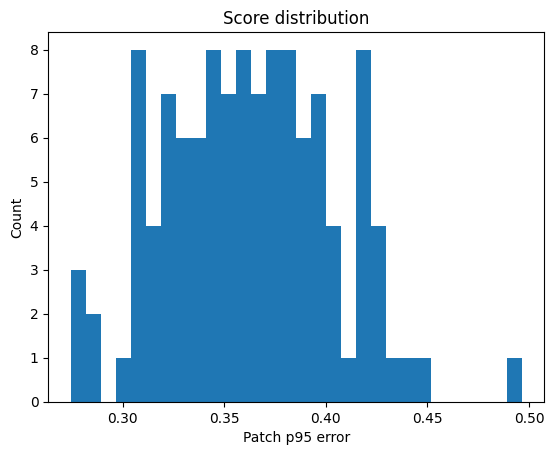

In [8]:
if USE_PATCH_SCORING:
    scores, heatmaps = das.evaluate_patch_scores(
        model, X_list, in_shape,
        window_seconds=PATCH_CFG["window_seconds"],
        window_meters=PATCH_CFG["window_meters"],
        stride_seconds=PATCH_CFG["stride_seconds"],
        stride_meters=PATCH_CFG["stride_meters"],
        fs_eff=fs_eff, mpc_eff=mpc_eff,
        reduce=PATCH_CFG["reduce"],
        device=device
    )
else:
    scores, per_file = das.evaluate_scores(model, X_list, in_shape, device)

print("Score range:", float(np.min(scores)), float(np.max(scores)))

# Optional histogram
import matplotlib.pyplot as plt
plt.hist(scores, bins=30)
plt.xlabel("Reconstruction error" if not USE_PATCH_SCORING else f"Patch {PATCH_CFG['reduce']} error")
plt.ylabel("Count")
plt.title("Score distribution")
plt.show()


### 7) Threshold & save results

In [9]:
is_anom, thr = das.choose_threshold(scores, percentile=95)
print(f"Threshold={thr:.4f} | Anomalies={int(is_anom.sum())}/{len(is_anom)}")

# Save CSV (minimal)
import csv, os
csv_name = "instance_scores_patch.csv" if USE_PATCH_SCORING else "instance_scores_snippet.csv"
csv_path = os.path.join(OUT_DIR, csv_name)
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    header = ["index", "score", "is_anomaly", "path"]
    w.writerow(header)
    for i, s in enumerate(scores):
        path = meta[i]["path"] if i < len(meta) else i
        w.writerow([i, f"{s:.6f}", int(is_anom[i]), path])
print("Wrote:", csv_path)


Threshold=0.4259 | Anomalies=6/117
Wrote: ./das_anomaly_results\instance_scores_patch.csv


### 8) Visualize top anomalies

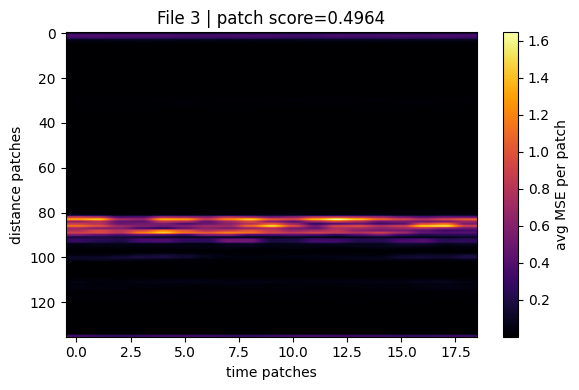

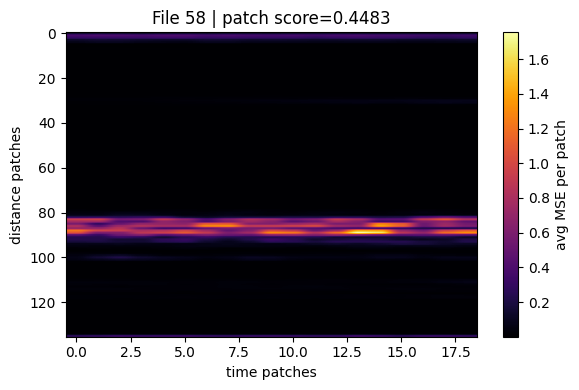

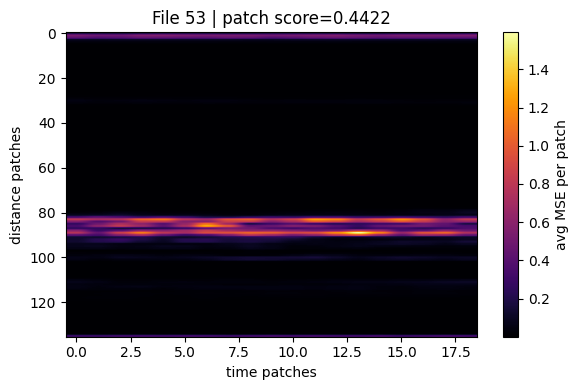

In [10]:
TOP_N = 3
top_idx = np.argsort(scores)[-TOP_N:][::-1]

if USE_PATCH_SCORING:
    # Show patch heatmaps of the top-N
    for i in top_idx:
        das.show_patch_heatmap(heatmaps[i], title=f"File {i} | patch score={scores[i]:.4f}")
else:
    # Original snippet-wise recon/error panels
    das.show_topN(model, X_list, scores, in_shape, N=TOP_N, device=device)


### 9)

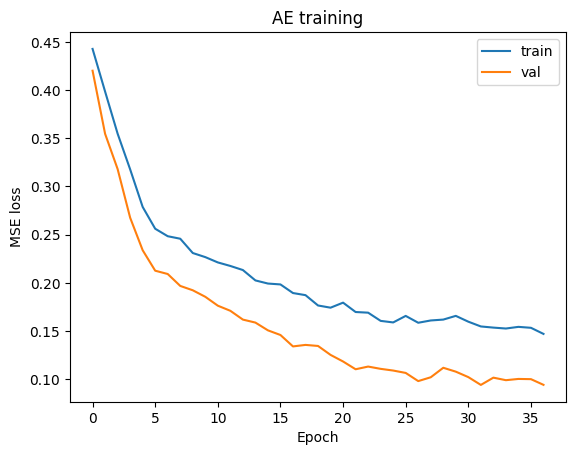

In [11]:
import matplotlib.pyplot as plt
plt.plot(hist["train"], label="train")
plt.plot(hist["val"], label="val")
plt.legend(); plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.title("AE training")
plt.show()
